# Create NERC/National figures
This notebook is where all national/NERC figures (not maps) are created. It contains code to import generation and CO₂ intensity results and uses some functions from `scr` to create figures.

## Instructions
The first part of this notebook imports and combines data. Subsequent sections generate different types of plots. Summary statistics of CO₂ intensity are available at the bottom of this notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from statsmodels.tsa.tsatools import detrend
# import statsmodels.formula.api as sm
import itertools
import sys
import calendar
import datetime
# sns.set()
idx = pd.IndexSlice

try:
    from pathlib import Path
except:
    pass

### Date string for filenames
This will be inserted into all filenames (reading and writing)

In [2]:
file_date = '2018-03-06'

In [3]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [4]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [5]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

%aimport Plots.plot
from Plots.plot import region_facet_grid, rolling_corr_plot, monthly_fuel_gen

## Load CO₂ intensity and percent gen data

### CO₂ intensity (aka *index*)

In [6]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data',
            'National index {}.csv'.format(file_date))
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [7]:
national_index.head()

year  month  generation (mwh)  elec fuel co2 (kg)  final co2 (kg)  \
0  2001      1      3.324839e+08        2.110627e+11    2.145929e+11   
1  2001      2      2.829402e+08        1.762658e+11    1.799442e+11   
2  2001      3      3.007065e+08        1.860660e+11    1.887242e+11   
3  2001      4      2.780781e+08        1.717565e+11    1.744977e+11   
4  2001      5      3.004857e+08        1.859817e+11    1.888085e+11   

   index (g/kwh)   datetime  quarter  index (lb/mwh)  change since 2005 nerc  
0     645.423413 2001-01-01        1     1422.900456           0.077267  USA  
1     635.979511 2001-02-01        1     1402.080431           0.061504  USA  
2     627.602684 2001-03-01        1     1383.612877           0.047523  USA  
3     627.513263 2001-04-01        2     1383.415739           0.047373  USA  
4     628.344387 2001-05-01        2     1385.248036           0.048761  USA

In [8]:
path = join(cwd, '..', 'Data storage',
            'final NERC data',
            '_NERC gen emissions and index {}.csv'.format(file_date))
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

### Percent generation

In [10]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National percent gen {}.csv'.format(file_date))
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'
national_per_gen.rename(columns={'generation (mwh)': '% generation'},
                        inplace=True)

In [11]:
national_per_gen.head()

year  month fuel category  elec fuel co2 (kg)  % generation   datetime nerc
0  2001      1          Coal                 0.0      0.533220 2001-01-01  USA
1  2001      2          Coal                 0.0      0.529212 2001-02-01  USA
2  2001      3          Coal                 0.0      0.516347 2001-03-01  USA
3  2001      4          Coal                 0.0      0.505867 2001-04-01  USA
4  2001      5          Coal                 0.0      0.504493 2001-05-01  USA

In [12]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC percent gen {}.csv'.format(file_date))
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])

### Absolute generation

In [14]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National generation {}.csv'.format(file_date))
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [16]:
index_cols = ['nerc', 'generation (mwh)', 'datetime']
nerc_gen = pd.merge(nerc_per_gen, nerc_index[index_cols],
                    on=['nerc', 'datetime'])
nerc_gen.rename(columns={'generation (mwh)' : 'total generation (mwh)'},
                inplace=True)
nerc_gen['generation (mwh)'] = (nerc_gen['% generation']
                                * nerc_gen['total generation (mwh)'])
nerc_gen.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)
nerc_gen.head()

% generation  total generation (mwh)  \
nerc fuel category datetime                                           
ASCC Coal          2001-01-01      0.051935              510124.027   
     Hydro         2001-01-01      0.203755              510124.027   
     Natural Gas   2001-01-01      0.615942              510124.027   
     Other         2001-01-01      0.128199              510124.027   
     Wind          2001-01-01      0.000170              510124.027   

                               generation (mwh)  
nerc fuel category datetime                      
ASCC Coal          2001-01-01         26493.302  
     Hydro         2001-01-01        103940.302  
     Natural Gas   2001-01-01        314206.726  
     Other         2001-01-01         65397.179  
     Wind          2001-01-01            86.518

#### Add generation by different fuel sources to get total generation by NERC

In [17]:
total = nerc_gen.groupby(['nerc', 'datetime'])['% generation',
                                               'generation (mwh)'].sum()
total['fuel category'] = 'Total'
total.set_index('fuel category', append=True, inplace=True)
total = total.reorder_levels(['nerc', 'fuel category', 'datetime'])
total.head()

% generation  generation (mwh)
nerc fuel category datetime                                  
ASCC Total         2001-01-01           1.0        510124.027
                   2001-02-01           1.0        457691.568
                   2001-03-01           1.0        493876.659
                   2001-04-01           1.0        417279.658
                   2001-05-01           1.0        409477.108

In [18]:
nerc_gen = pd.concat([nerc_gen, total])
nerc_gen.sort_index(inplace=True)

In [19]:
nerc_gen.head()

% generation  generation (mwh)  \
nerc fuel category datetime                                     
ASCC Coal          2001-01-01      0.051935         26493.302   
                   2001-02-01      0.068307         31263.704   
                   2001-03-01      0.057626         28459.894   
                   2001-04-01      0.049022         20455.924   
                   2001-05-01      0.058848         24096.734   

                               total generation (mwh)  
nerc fuel category datetime                            
ASCC Coal          2001-01-01              510124.027  
                   2001-02-01              457691.568  
                   2001-03-01              493876.659  
                   2001-04-01              417279.658  
                   2001-05-01              409477.108

## Load capacity by month, fuel, nerc

In [20]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Plant Capacity', 'monthly capacity by fuel.csv')

capacity = pd.read_csv(path, index_col=['nerc', 'fuel category', 'datetime'],
                       parse_dates=['datetime'])
capacity.drop(['year', 'month'], axis=1, inplace=True)

In [21]:
capacity.head()

active capacity  possible gen
nerc fuel category datetime                                 
ASCC Coal          2001-01-01             54.1       40250.4
                   2001-02-01             54.1       36355.2
                   2001-03-01             54.1       40250.4
                   2001-04-01             54.1       38952.0
                   2001-05-01             54.1       40250.4

## Load split of natural gas capacity by prime mover type

In [22]:
path = join(cwd, '..', 'Data storage', 'Derived data',
            'Plant Capacity', 'monthly natural gas split.csv')

ng_capacity_type = pd.read_csv(path)
ng_capacity_type.head()

nerc  year  month   ngcc  turbine  other  total  ngcc fraction  \
0  ASCC  2001      1  214.4    592.4    3.0  809.8       0.264757   
1  ASCC  2001      2  214.4    592.4    3.0  809.8       0.264757   
2  ASCC  2001      3  214.4    592.4    3.0  809.8       0.264757   
3  ASCC  2001      4  214.4    592.4    3.0  809.8       0.264757   
4  ASCC  2001      5  214.4    592.4    3.0  809.8       0.264757   

   turbine fraction  other fraction    datetime  
0          0.731539        0.003705  2001-01-01  
1          0.731539        0.003705  2001-02-01  
2          0.731539        0.003705  2001-03-01  
3          0.731539        0.003705  2001-04-01  
4          0.731539        0.003705  2001-05-01

In [23]:
ng_type_avg = (ng_capacity_type.reset_index()
                               .groupby(['nerc', 'year'])
                               .mean())
ng_type_avg.head()

index  month   ngcc  turbine  other    total  ngcc fraction  \
nerc year                                                                
ASCC 2001    5.5    6.5  214.4  594.900    3.0  812.300       0.263944   
     2002   17.5    6.5  252.3  597.400    3.0  852.700       0.295884   
     2003   29.5    6.5  252.3  584.900    3.0  840.200       0.300286   
     2004   41.5    6.5  252.3  590.025    3.0  845.325       0.298497   
     2005   53.5    6.5  252.3  579.700    3.0  835.000       0.302156   

           turbine fraction  other fraction  
nerc year                                    
ASCC 2001          0.732362        0.003693  
     2002          0.700598        0.003518  
     2003          0.696144        0.003571  
     2004          0.697954        0.003549  
     2005          0.694251        0.003593

## Combine NERC and national results

### CO₂ intensity

In [24]:
index = pd.concat([national_index, nerc_index])

In [25]:
index.head()

change since 2005   datetime  elec fuel co2 (kg)  final co2 (kg)  \
0           0.077267 2001-01-01        2.110627e+11    2.145929e+11   
1           0.061504 2001-02-01        1.762658e+11    1.799442e+11   
2           0.047523 2001-03-01        1.860660e+11    1.887242e+11   
3           0.047373 2001-04-01        1.717565e+11    1.744977e+11   
4           0.048761 2001-05-01        1.859817e+11    1.888085e+11   

   generation (mwh)  index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0      3.324839e+08     645.423413     1422.900456      1  USA      1.0  2001  
1      2.829402e+08     635.979511     1402.080431      2  USA      1.0  2001  
2      3.007065e+08     627.602684     1383.612877      3  USA      1.0  2001  
3      2.780781e+08     627.513263     1383.415739      4  USA      2.0  2001  
4      3.004857e+08     628.344387     1385.248036      5  USA      2.0  2001

### Percent generation

In [26]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])

per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [27]:
per_gen.head()

% generation   datetime  elec fuel co2 (kg) fuel category  month nerc  year
0      0.533220 2001-01-01                 0.0          Coal      1  USA  2001
1      0.529212 2001-02-01                 0.0          Coal      2  USA  2001
2      0.516347 2001-03-01                 0.0          Coal      3  USA  2001
3      0.505867 2001-04-01                 0.0          Coal      4  USA  2001
4      0.504493 2001-05-01                 0.0          Coal      5  USA  2001

### Total generation

In [28]:
national_gen.head()

fuel category  year  month  generation (mwh)   datetime nerc
0          Coal  2001      1       177287111.0 2001-01-01  USA
1          Coal  2001      2       149735483.0 2001-02-01  USA
2          Coal  2001      3       155269010.0 2001-03-01  USA
3          Coal  2001      4       140670652.0 2001-04-01  USA
4          Coal  2001      5       151592915.0 2001-05-01  USA

In [29]:
cols = ['nerc', 'fuel category', 'datetime']
gen = pd.concat([national_gen.set_index(cols), nerc_gen])
gen.sort_index(inplace=True)
gen.drop(['% generation', 'total generation (mwh)'], axis=1,
         inplace=True)

In [30]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

## Figures

In [53]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('paper', font_scale=1.0)

#### Color palette for fuel categories
Use the Tableau 10 color palette

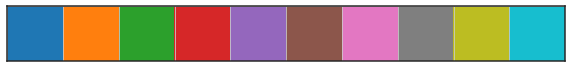

In [54]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

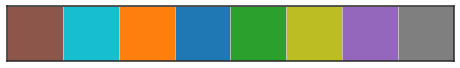

In [55]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

### Total generation

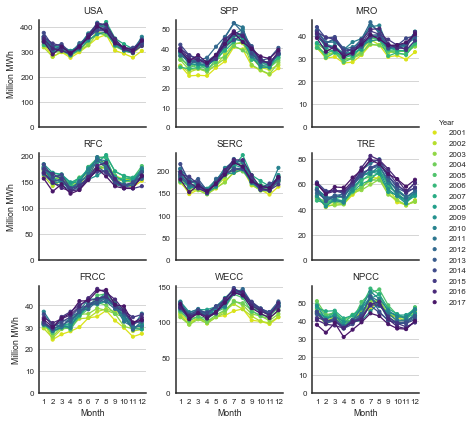

In [56]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['generation (mwh)'] /= 1E6

# temp.rename(columns={'month': 'Month',
#                      'year': 'Year'}, inplace=True)
with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='generation (mwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2, sharey=False)
    
    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, None)
        
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Million MWh')
            
path = join(cwd, '..', 'Figures', 'Monthly generation {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

### Index figure

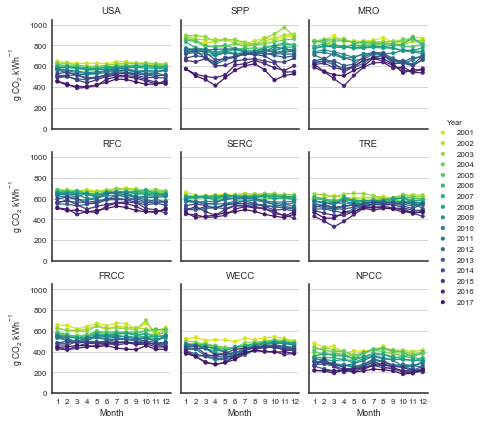

In [57]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.reset_index()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g $\mathregular{CO_2 \ kWh^{-1}}$')
            
path = join(cwd, '..', 'Figures',
            'Monthly index (12-months) {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

#### Alternate plot of CO₂ intensity

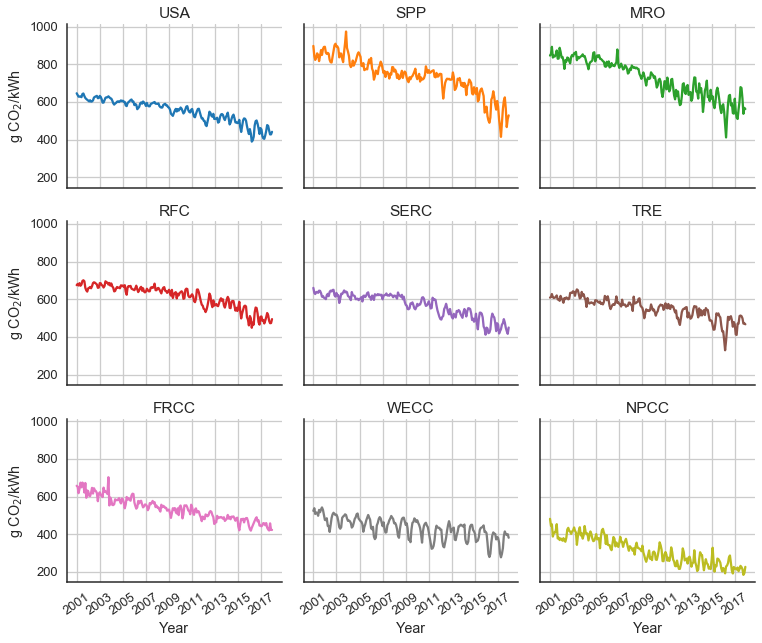

In [58]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index by region.pdf')
plt.savefig(path, bbox_inches='tight')

#### Plot of detrended intensity, using a linear detrend
Not a good method - trend isn't linear

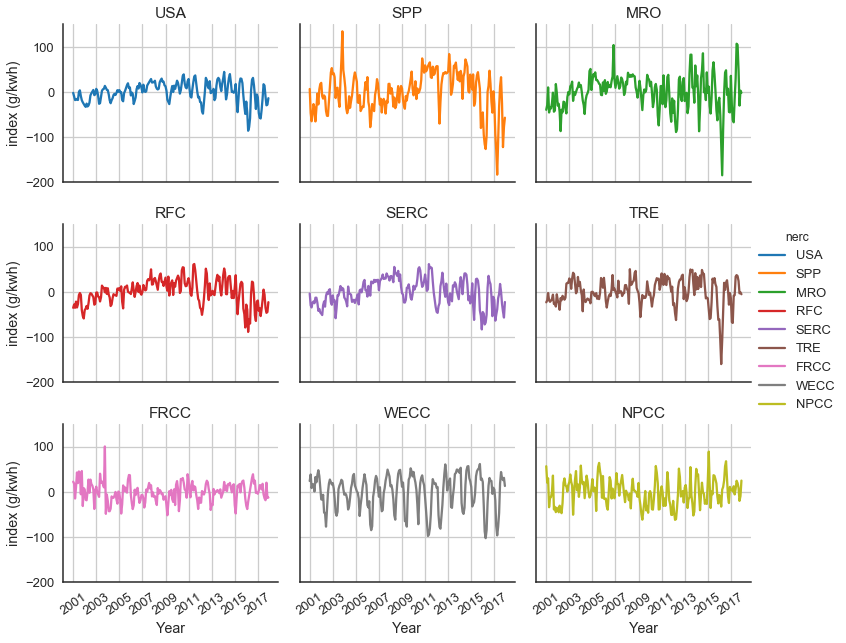

In [59]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend
Better than linear, but I'm not sure it's appropriate

In [60]:
def diff_detrend(series, n=1):
    d = series - series.shift(n)
    return d

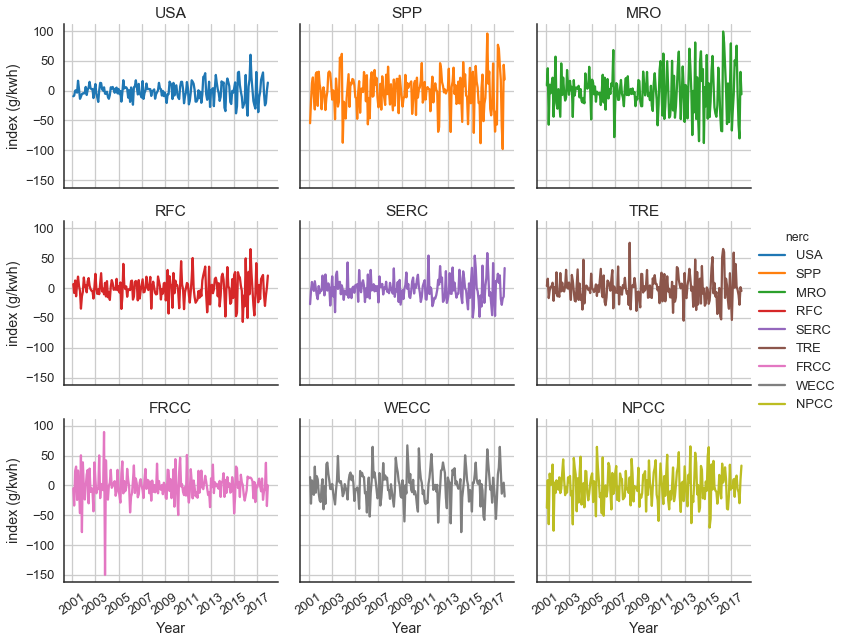

In [61]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Detrend by subtracting the rolling 1-year mean

Started by using `seasonal_decompose` from statsmodels. It was apparent that the `trend` component is just the rolling average. I'm leaving the extra code here as documentation of this fact.

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/Home/anaconda/envs/psci/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [63]:
wecc = index.loc[index['nerc'] == 'WECC', ['index (g/kwh)', 'datetime']]
wecc.set_index('datetime', inplace=True)
wecc.head()

index (g/kwh)
datetime                 
2001-01-01     524.224297
2001-02-01     538.017787
2001-03-01     507.386562
2001-04-01     515.615166
2001-05-01     513.664334

In [64]:
sd = seasonal_decompose(wecc)

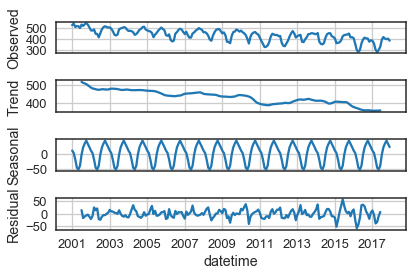

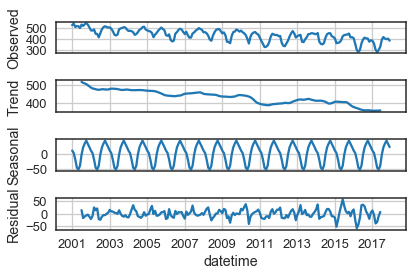

In [65]:
sd.plot()

These three things are all the same:
1. Subtracting just the *trend* from the `WECC` data
2. Adding the *seasonal* and *resid* components
3. Subtracting the annual rolling mean from the `WECC` data

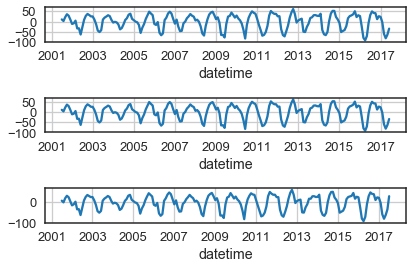

In [66]:
fig, ax = plt.subplots(nrows=3, squeeze=True)
(wecc - sd.trend).plot(ax=ax[0], legend=False)
(sd.seasonal + sd.resid).plot(ax=ax[1], legend=False)
(wecc - wecc.rolling(12, center=True).mean()).plot(ax=ax[2], legend=False)
plt.tight_layout()

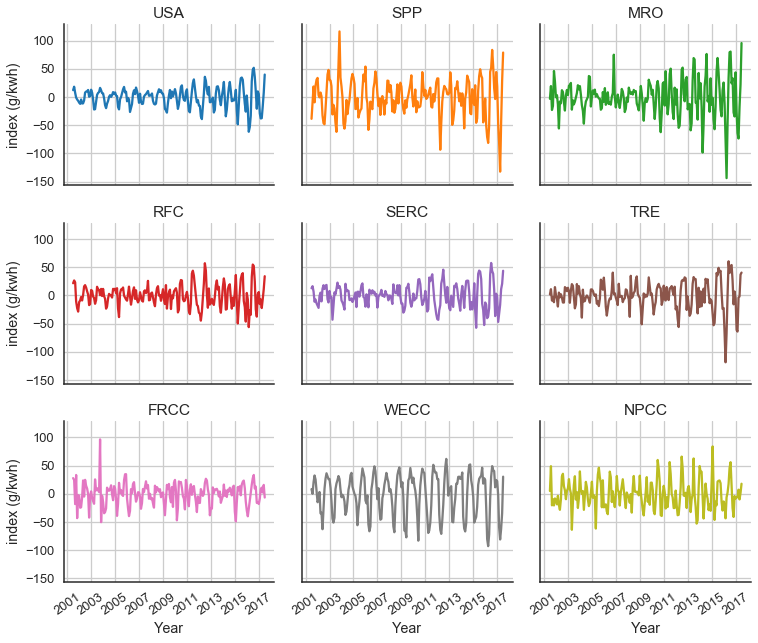

In [67]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Create a combined figure for the SI
Include the raw monthly data, the rolling mean trend line, and the detrended data

In [68]:
temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

In [69]:
combined = index.copy()
combined.set_index(['nerc', 'datetime'], inplace=True)
df = detrend_index.reset_index(drop=False).set_index(['nerc', 'datetime'])
df.columns = ['detrend index']

In [70]:
combined = pd.concat([index.set_index(['nerc', 'datetime']), df])

In [71]:
combined.head()

change since 2005  detrend index  elec fuel co2 (kg)  \
nerc datetime                                                           
USA  2001-01-01           0.077267            NaN        2.110627e+11   
     2001-02-01           0.061504            NaN        1.762658e+11   
     2001-03-01           0.047523            NaN        1.860660e+11   
     2001-04-01           0.047373            NaN        1.717565e+11   
     2001-05-01           0.048761            NaN        1.859817e+11   

                 final co2 (kg)  generation (mwh)  index (g/kwh)  \
nerc datetime                                                      
USA  2001-01-01    2.145929e+11      3.324839e+08     645.423413   
     2001-02-01    1.799442e+11      2.829402e+08     635.979511   
     2001-03-01    1.887242e+11      3.007065e+08     627.602684   
     2001-04-01    1.744977e+11      2.780781e+08     627.513263   
     2001-05-01    1.888085e+11      3.004857e+08     628.344387   

                 index (lb/mwh)  month  quarter    year  
nerc datetime                                            
USA  2001-01-01     1422.900456    1.0      1.0  2001.0  
     2001-02-01     1402.080431    2.0      1.0  2001.0  
     2001-03-01     1383.612877    3.0      1.0  2001.0  
     2001-04-01     1383.415739    4.0      2.0  2001.0  
     2001-05-01     1385.248036    5.0      2.0  2001.0

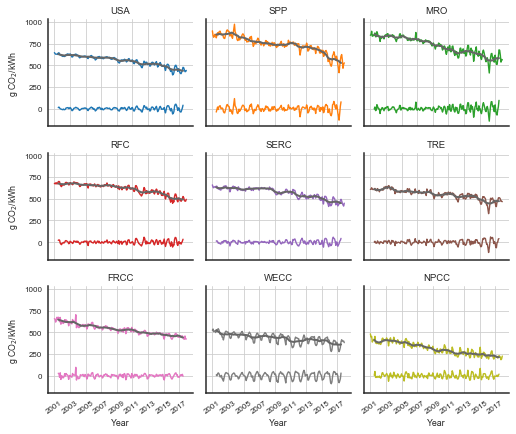

In [72]:
def plot_trend(x, y, **kws):
    'Plot function for the FacetGrid to plot all three data series'
    trend = y.rolling(12, center=True).mean()
    plt.plot(x, y, **kws)
    plt.plot(x, trend, lw=2, c='0.4')
    detrended = y - trend
    plt.plot(x, detrended, **kws)

order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10',
                 size=2)

region_facet_grid(df=index.reset_index(), plot_function=plot_trend, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='paper', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI',
            'Monthly index trend and detrended by region {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

### Percent gen figures

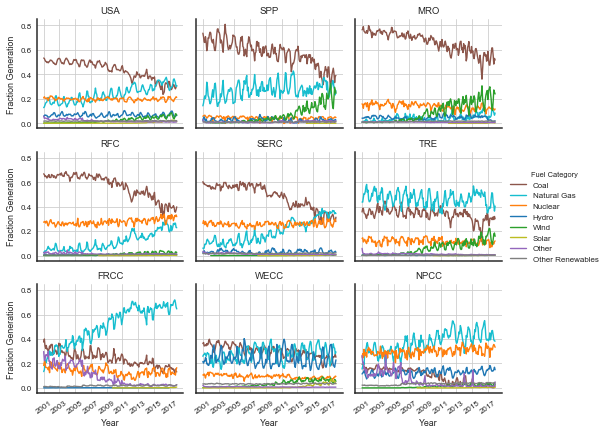

In [73]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette,
                 size=2)

g = region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='% generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  y_label='Fraction Generation',
                  context='paper', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## Capacity factor of each fuel by month

In [74]:
capacity['Capacity Factor'] = (gen.loc[:, 'generation (mwh)'] 
                               / capacity.loc[:, 'possible gen'])

### Annual capacity factors
Requested by reviewer as part of final revisions.

In [75]:
# Check annual capacity factors

# need to add a year column for groupby
capacity['year'] = capacity.index.get_level_values('datetime').year

gen['year'] = gen.index.get_level_values('datetime').year


annual_cf = (gen.groupby(['nerc', 'fuel category', 'year'])['generation (mwh)'].sum()
                .div(capacity.groupby(['nerc', 'fuel category', 'year'])['possible gen'].sum()))

In [76]:
# Annual coal CF since 2014
annual_cf.unstack().loc[idx[:, 'Coal'], 2014:]

year                    2014      2015      2016      2017
nerc fuel category                                        
ASCC Coal           0.613988  0.734145  0.478458  0.149795
FRCC Coal           0.590910  0.475253  0.455963  0.440205
HICC Coal           0.958386  0.809775  0.947037  0.872478
MRO  Coal           0.667566  0.629204  0.592030  0.616069
NPCC Coal           0.263495  0.176457  0.134279  0.093923
RFC  Coal           0.583916  0.525260  0.495332  0.482226
SERC Coal           0.594136  0.508166  0.505878  0.486285
SPP  Coal           0.654900  0.577541  0.527465  0.516552
TRE  Coal           0.710524  0.564938  0.582903  0.665722
USA  Coal           0.619880  0.549530  0.523666  0.522770
WECC Coal           0.735250  0.692965  0.622483  0.638176

### Monthly CF plots

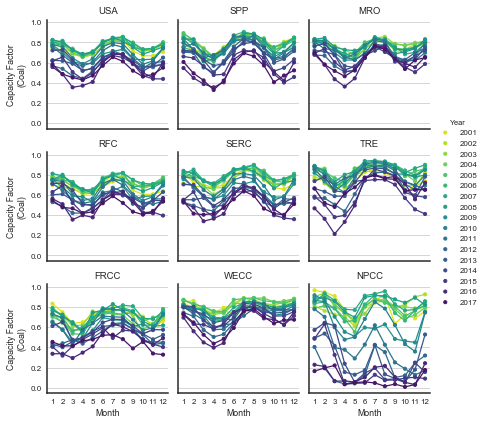

In [77]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor\n(Coal)')
            
path = join(cwd, '..', 'Figures', 'SI', 'Monthly Coal CF {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

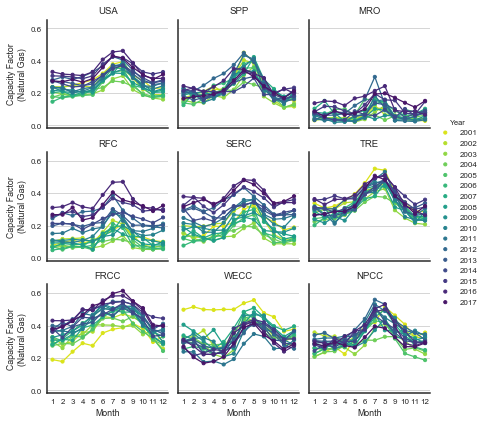

In [78]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('paper', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=2)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor\n(Natural Gas)')
            
path = join(cwd, '..', 'Figures', 'SI', 'Monthly Natural Gas CF {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

## Plot of natural gas capacity type by NERC

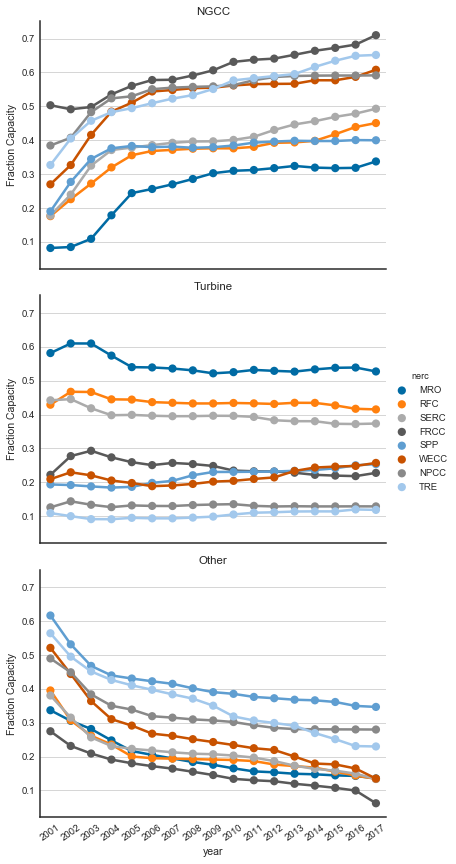

In [67]:
order = ['MRO', 'RFC', 'SERC', 'FRCC', 'SPP', 'WECC', 'NPCC', 'TRE']

# Melt the wide dataframe into tidy format for plotting
temp = (ng_type_avg.reset_index()
                   .melt(id_vars=['nerc', 'year'],
                         value_vars=['ngcc fraction', 'turbine fraction', 'other fraction'],
                         var_name='type', value_name='fraction capacity'))

# Use the new tableau colorblind10 palette
with plt.style.context('tableau-colorblind10'):
    g = sns.factorplot(x='year', y='fraction capacity', data=temp, hue='nerc',
                       row='type', hue_order=order,
                       scale=1, aspect=1.4, ci=0).set_xticklabels(rotation=35)
    g.set_axis_labels(y_var='Fraction Capacity')
    
    #rename each of the subplot titles
    axs = g.axes.ravel()
    for ax, title in zip(axs, ['NGCC', 'Turbine', 'Other']):
        ax.set_title(title)
    
path = join(cwd, '..', 'Figures', 'SI', 'Natural gas capacity by type.pdf')
plt.savefig(path, bbox_inches='tight')

## Monthly generation by each fuel type

In [44]:
def monthly_fuel_gen(gen_df, fuel, folder, file_type='pdf', dpi=350, save=False):
    """
    Make a FacetGrid plot of monthly generation for a single fuel category
    
    inputs:
        gen_df (dataframe): monthly generation for all fuels
        fuel (string): name of the fuel category to plot
        folder (path): folder where the plot should be saved
        file_type (string): file format (e.g. pdf, png, etc)
        dpi (int): dots per inch resolution for saved file (if not pdf)
        save (bool): if True, save the file
            
    """
    order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
    temp = gen.loc[idx[:, fuel, :], :].reset_index()
    temp['Month'] = temp['datetime'].dt.month
    temp['Year'] = temp['datetime'].dt.year
    temp['million mwh'] = temp['generation (mwh)'] / 1e6

    with sns.plotting_context('paper', font_scale=1):

        g = sns.factorplot(x='Month', y='million mwh', hue='Year', sharey=False,
                           data=temp, col='nerc', col_wrap=3, col_order=order, 
                           palette='viridis_r', scale=0.5, size=2)

        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
            ax.set_ylim(0, None)
    #         ax.set_ylim(0, 1050)
            if title in ['USA', 'RFC', 'FRCC']:
                ax.set_ylabel('Million MWh\n({})'.format(fuel))

    path = join(folder, 'Monthly {} gen {}.{}'.format(fuel, file_date, file_type))
    if save:
        plt.savefig(path, bbox_inches='tight', dpi=dpi)
    
    

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Coal gen 2018-03-06.pdf


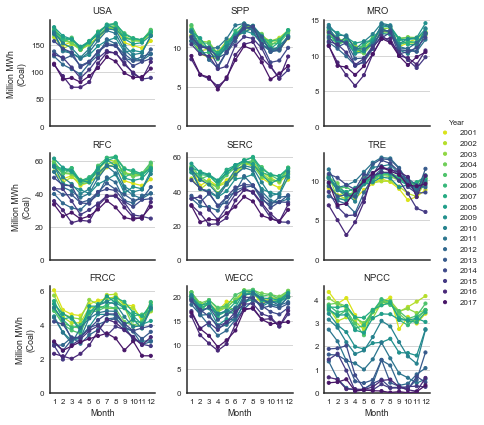

In [46]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Coal', folder=folder_path, file_type='pdf', save=True)

In [62]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN  2001
                   2001-02-01         31263.704    NaN  2001
                   2001-03-01         28459.894    NaN  2001
                   2001-04-01         20455.924    NaN  2001
                   2001-05-01         24096.734    NaN  2001

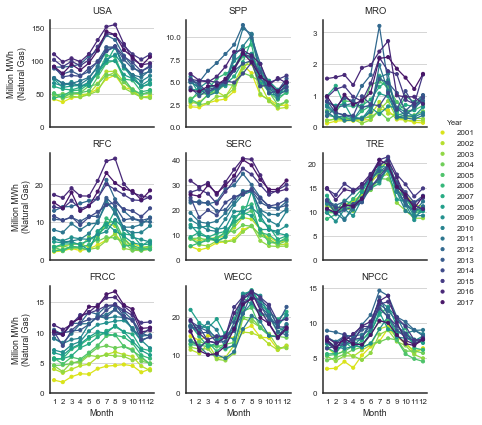

In [67]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Natural Gas', folder=folder_path, file_date=file_date,
                 file_type='pdf', save=False)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Natural Gas gen 2018-03-06.pdf


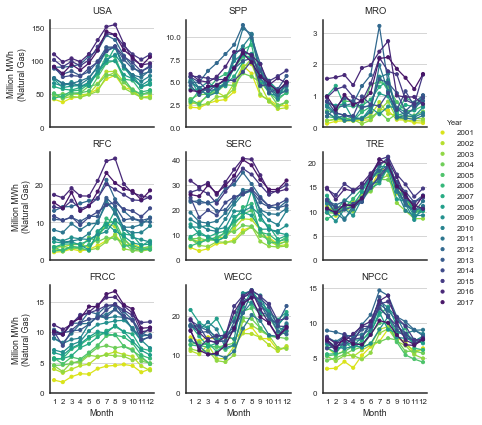

In [45]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Natural Gas', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Nuclear gen 2018-03-06.pdf


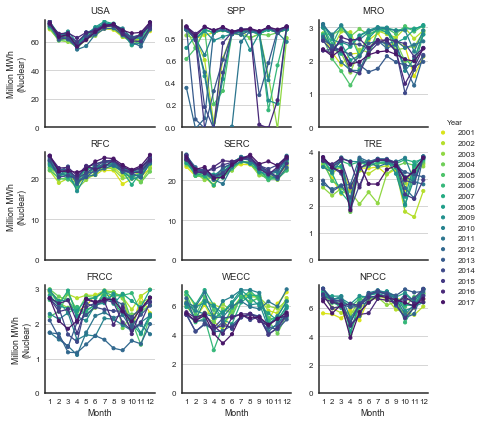

In [47]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Nuclear', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Wind gen 2018-03-06.pdf


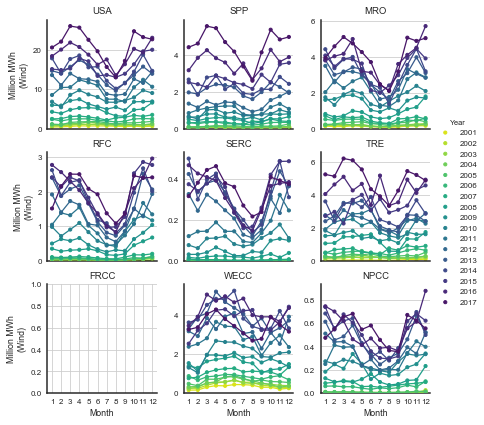

In [48]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Wind', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Solar gen 2018-03-06.pdf


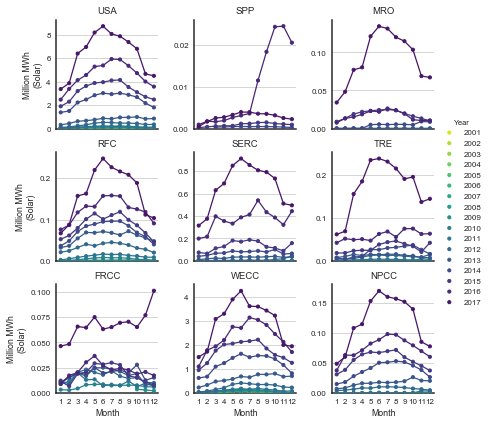

In [49]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Solar', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Other gen 2018-03-06.pdf


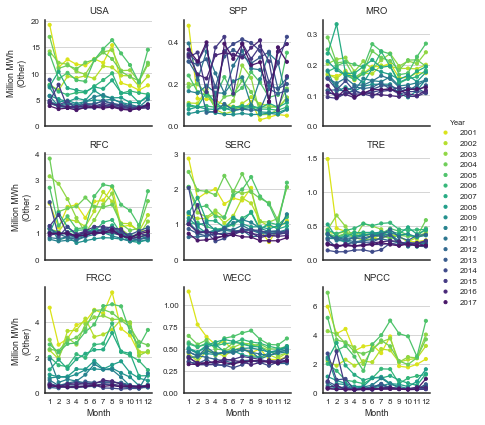

In [50]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Other', folder=folder_path, file_type='pdf', save=True)

/Users/Home/Documents/GitHub/Index-variability/Notebooks/../Figures/SI/Monthly Other Renewables gen 2018-03-06.pdf


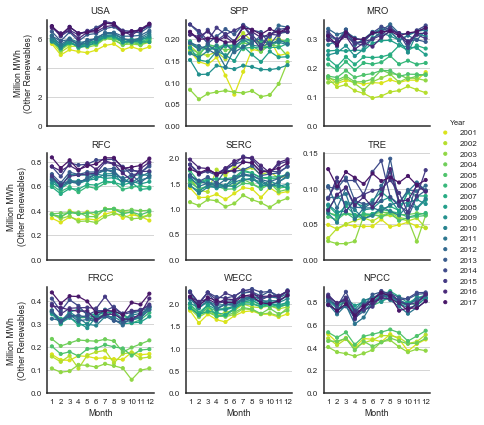

In [51]:
folder_path = join(cwd, '..', 'Figures', 'SI')
monthly_fuel_gen(gen, fuel='Other Renewables', folder=folder_path, file_type='pdf', save=True)

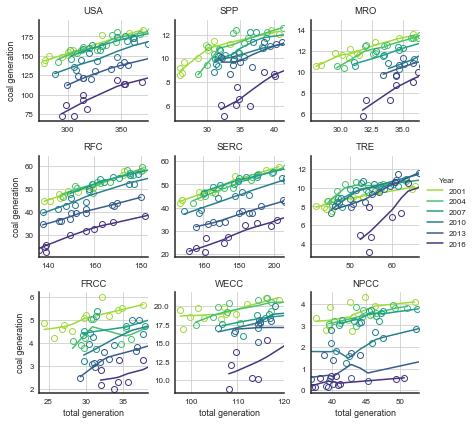

In [108]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
years = range(2001, 2017, 3)
temp = gen.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['coal generation'] = temp['generation (mwh)'] / 1e6
temp = temp.loc[temp['Year'].isin(years), :]

total_gen = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
total_gen.rename(columns={'generation (mwh)': 'total generation'}, inplace=True)
total_gen['total generation'] /= 1e6

temp = temp.merge(total_gen, on=['nerc', 'datetime'])

def scatter_coal_total(x, y, *args, **kwargs):
    plt.plot(x, y, 'o', markersize=6, markeredgewidth=1, markerfacecolor='None', **kwargs)
    line_kws = dict(linewidth=1.5)
    sns.regplot(x, y, x_ci=None, lowess=True, n_boot=1, line_kws=line_kws,
                scatter=False, **kwargs)

with sns.plotting_context('paper', font_scale=1):

    g = sns.FacetGrid(data=temp, hue='Year', sharey=False, sharex=False,
                      col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', size=2)
    g.map(scatter_coal_total, 'total generation', 'coal generation')
    g.add_legend()

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
#         if title in ['USA', 'RFC', 'FRCC']:
#             ax.set_ylabel('Million MWh Coal')
            
path = join(cwd, '..', 'Figures', 'Total vs coal gen {}.pdf'.format(file_date))
# plt.savefig(path, bbox_inches='tight')

In [112]:
g._legend_data['2001'].get_linewidth()

1.5

## Figure of wind, nat gas, and coal
Show how generation from these three resources has changed over time in SPP, TRE, and MRO.

In [159]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

% generation   datetime  elec fuel co2 (kg) fuel category  month nerc  \
3639      0.748146 2005-01-01                 NaN          Coal      1  MRO   
3640      0.754733 2005-02-01                 NaN          Coal      2  MRO   
3641      0.753462 2005-03-01                 NaN          Coal      3  MRO   
3642      0.751070 2005-04-01                 NaN          Coal      4  MRO   
3643      0.748846 2005-05-01                 NaN          Coal      5  MRO   

      year  
3639  2005  
3640  2005  
3641  2005  
3642  2005  
3643  2005

In [160]:
index.head()

change since 2005   datetime  elec fuel co2 (kg)  final co2 (kg)  \
0           0.077267 2001-01-01        2.110627e+11    2.145929e+11   
1           0.061504 2001-02-01        1.762658e+11    1.799442e+11   
2           0.047523 2001-03-01        1.860660e+11    1.887242e+11   
3           0.047373 2001-04-01        1.717565e+11    1.744977e+11   
4           0.048761 2001-05-01        1.859817e+11    1.888085e+11   

   generation (mwh)  index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0      3.324839e+08     645.423413     1422.900456      1  USA      1.0  2001  
1      2.829402e+08     635.979511     1402.080431      2  USA      1.0  2001  
2      3.007065e+08     627.602684     1383.612877      3  USA      1.0  2001  
3      2.780781e+08     627.513263     1383.415739      4  USA      2.0  2001  
4      3.004857e+08     628.344387     1385.248036      5  USA      2.0  2001

In [161]:
capacity.head()

active capacity  possible gen  Capacity Factor  \
nerc fuel category datetime                                                     
ASCC Coal          2001-01-01             54.1       40250.4         0.658212   
                   2001-02-01             54.1       36355.2         0.859951   
                   2001-03-01             54.1       40250.4         0.707071   
                   2001-04-01             54.1       38952.0         0.525157   
                   2001-05-01             54.1       40250.4         0.598671   

                               year  
nerc fuel category datetime          
ASCC Coal          2001-01-01  2001  
                   2001-02-01  2001  
                   2001-03-01  2001  
                   2001-04-01  2001  
                   2001-05-01  2001

In [75]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    'Add classifications to each month based on the year'
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2017'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index.reset_index()[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, '% generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

# temp_df = temp_df.merge(capacity.reset_index(), how='left',
#                         on=['nerc', 'fuel category', 'datetime'])

if 'year_x' in temp_df.columns:
    temp_df.rename(columns={'year_x': 'year'}, inplace=True)

In [76]:
temp_df.head()

% generation   datetime  elec fuel co2 (kg) fuel category  month nerc  \
0      0.748146 2005-01-01                 NaN          Coal      1  MRO   
1      0.029781 2005-01-01                 NaN   Natural Gas      1  MRO   
2      0.012254 2005-01-01                 NaN          Wind      1  MRO   
3      0.754733 2005-02-01                 NaN          Coal      2  MRO   
4      0.033670 2005-02-01                 NaN   Natural Gas      2  MRO   

   year  timeframe  generation (mwh)  generation  
0  2005  2005-2008      1.820807e+07   13.622289  
1  2005  2005-2008      1.820807e+07    0.542249  
2  2005  2005-2008      1.820807e+07    0.223117  
3  2005  2005-2008      1.515471e+07   11.437763  
4  2005  2005-2008      1.515471e+07    0.510253

In [45]:
# a is the list of colors
# Matching fuel colors to the generation plot above
a = fuel_palette[0:2]
a.append(fuel_palette[4])

### seaborn tsplot issues
When running the full code below (tsplot within a FacetGrid) I'm getting an error. The data works for tsplot

/Users/Home/anaconda/envs/psci/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


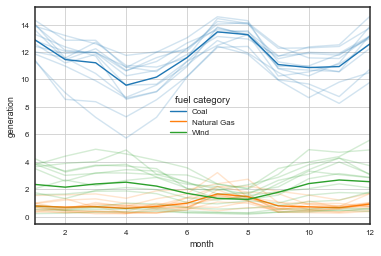

In [77]:
sns.tsplot(temp_df.loc[temp_df.nerc=='MRO'], time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces')

/Users/Home/anaconda/envs/psci/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


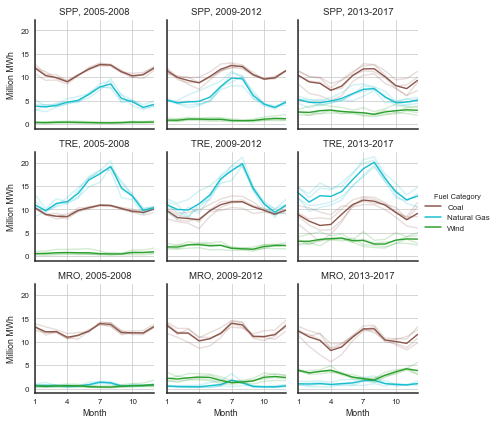

In [117]:
from matplotlib.lines import Line2D
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2017']

with sns.plotting_context(font_scale=1):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order,# aspect=1.2,
                      size=2)
#     g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
#                     condition='fuel category', err_style='unit_traces',
#                     color=a)
    
    
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    
    # This is hacky, but I'm having trouble gettign tsplot to work with FacetGrid
    # As a workaround, manually pass data from g.facet_data() - which returns a
    # tuple - to tsplot for every axis of the figure. Then manually set the axis
    # labels and create the legend.
    for ax, title, data in zip(axes, titles, g.facet_data()):
        sns.tsplot(data[-1], time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a, ax=ax, legend=False)
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if '2005' in title:
            ax.set_ylabel('Million MWh')
            
        if 'MRO' in title:
            ax.set_xlabel('Month')
    
    # Need to use tight_layout to get the facet spacing correct
    g.fig.tight_layout()
    
    # Create legend lines
    legend_lines = {fuel: Line2D([0], [0], color=c, lw=1.5, label=fuel)
                    for c, fuel in zip(a, ['Coal', 'Natural Gas', 'Wind'])}
    g.add_legend(legend_data=legend_lines, title='Fuel Category')
            
path = join(cwd, '..', 'Figures',
            '_Wind-Coal-NG variability tsplot {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

In [98]:
g._legend_data

{}

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


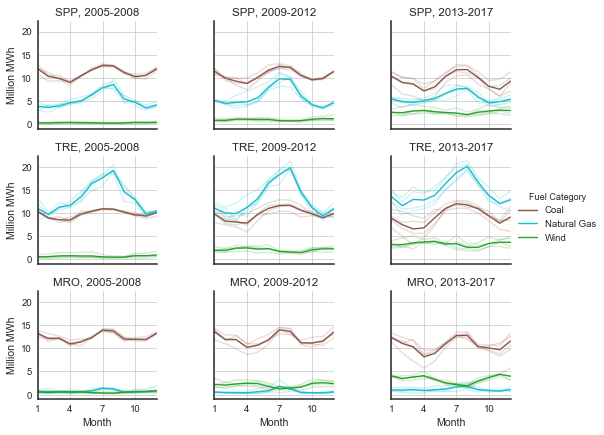

In [66]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2017']

with sns.plotting_context(font_scale=1):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.2,
                      size=2)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures',
            'Wind-Coal-NG variability tsplot {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

In [126]:
def rolling_norm_std_plot(temp_df, window=24):
    rolling_var_list = []
    for nerc in ['TRE', 'SPP', 'MRO']:
        for fuel in ['Coal', 'Natural Gas', 'Wind']:
            _df = temp_df.loc[(temp_df['nerc'] == nerc) &
                              (temp_df['fuel category'] == fuel),
                             ['nerc', 'fuel category', 'datetime', 'generation']]

            # I'm using std to mean variability
            _df['variability'] = (_df['generation']
                                  .rolling(window, center=True)
                                  .std())
            _df['variance'] = (_df['generation']
                                  .rolling(window, center=True)
                                  .var())
            _df['mean'] = (_df['generation']
                                  .rolling(window, center=True)
                                  .mean())

            _df['norm variability'] = _df['variability'] / _df['mean']

            _df['dispersion'] = _df['variance'] / _df['mean']

            rolling_var_list.append(_df)

    rolling_var_df = pd.concat(rolling_var_list)
    
    g = sns.FacetGrid(rolling_var_df, hue='fuel category', col='nerc', 
                  col_order=['SPP', 'TRE', 'MRO'], palette=a, size=2)
    g.map(plt.plot, 'datetime', 'norm variability').add_legend(title='Fuel Category')
    g.set_xticklabels(rotation=25)

    g.set_axis_labels('Year', 'Normalized Variability')
    axes = g.axes.flatten()
    for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
        ax.set_title(nerc)

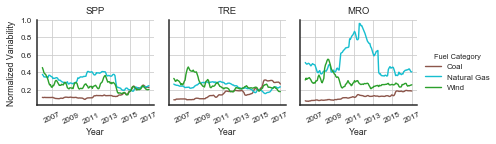

In [128]:
rolling_norm_std_plot(temp_df, window=24)
path = join(cwd, '..', 'Figures',
            'Wind-Coal-NG norm rolling variability {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

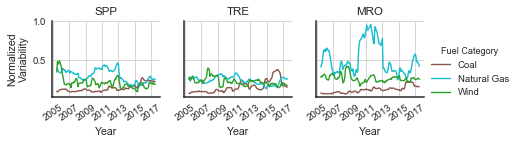

In [57]:
rolling_norm_std_plot(temp_df, window=12)

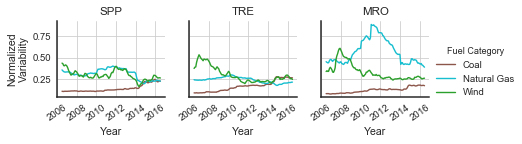

In [58]:
rolling_norm_std_plot(temp_df, window=36)

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [79]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('RFC', 'MRO'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [80]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

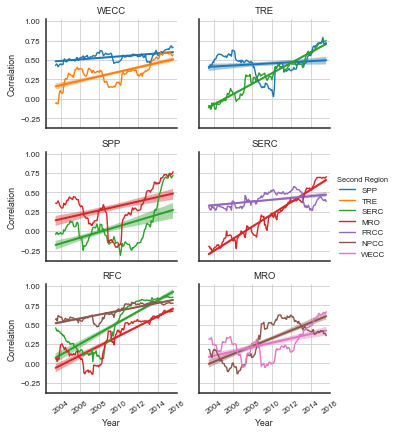

In [81]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                       detrend_series=True, seasonal=True, fill_alpha=0.4)
path = join(cwd, '..', 'Figures',
            'Rolling correlation - seasonal detrend 48m centered {}.pdf'.format(file_date))
plt.savefig(path, bbox_inches='tight')

#### Additional rolling windows for comparison and the SI

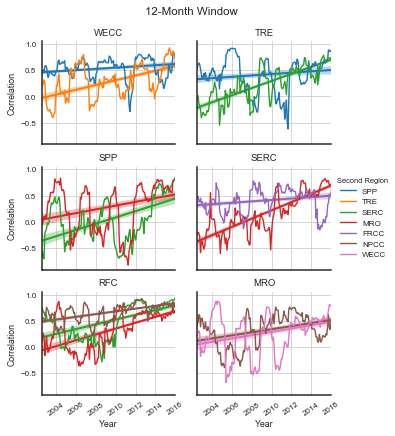

In [82]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12,
                  detrend_series=True, seasonal=True,
                  sup_title='12-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 12m centered.pdf')
plt.savefig(path, bbox_inches='tight')

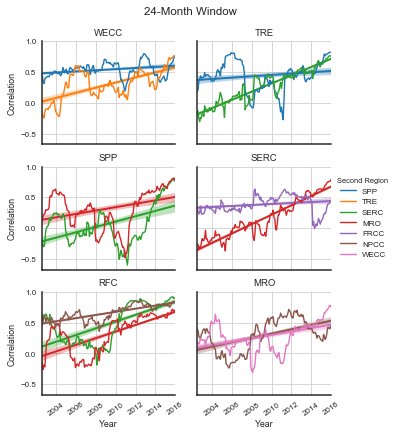

In [83]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24,
                  detrend_series=True, seasonal=True,
                  sup_title='24-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 24m centered.pdf')
plt.savefig(path, bbox_inches='tight')

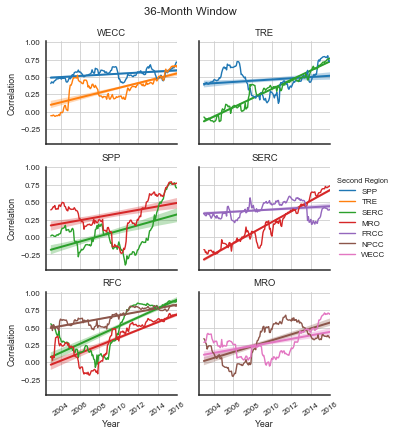

In [84]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36,
                  detrend_series=True, seasonal=True, 
                  sup_title='36-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 36m centered.pdf')
plt.savefig(path, bbox_inches='tight')

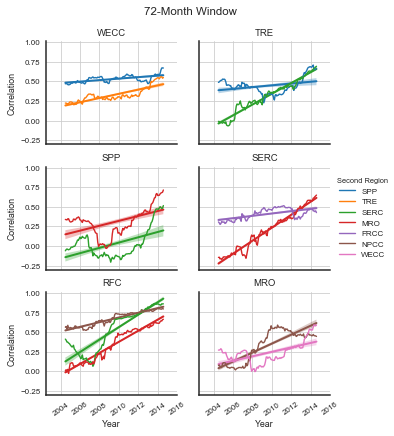

In [85]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72,
                  detrend_series=True, seasonal=True,
                  sup_title='72-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 72m centered.pdf')
plt.savefig(path, bbox_inches='tight')

## Changes in CO₂ intensity for each NERC region

In [31]:
index.head()

change since 2005   datetime  elec fuel co2 (kg)  final co2 (kg)  \
0           0.077267 2001-01-01        2.110627e+11    2.145929e+11   
1           0.061504 2001-02-01        1.762658e+11    1.799442e+11   
2           0.047523 2001-03-01        1.860660e+11    1.887242e+11   
3           0.047373 2001-04-01        1.717565e+11    1.744977e+11   
4           0.048761 2001-05-01        1.859817e+11    1.888085e+11   

   generation (mwh)  index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0      3.324839e+08     645.423413     1422.900456      1  USA      1.0  2001  
1      2.829402e+08     635.979511     1402.080431      2  USA      1.0  2001  
2      3.007065e+08     627.602684     1383.612877      3  USA      1.0  2001  
3      2.780781e+08     627.513263     1383.415739      4  USA      2.0  2001  
4      3.004857e+08     628.344387     1385.248036      5  USA      2.0  2001

In [32]:
annual_index = (index#.drop('index', axis=1)
                     #.reset_index()
                     .groupby(['year', 'nerc'])
                     .sum())
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.sort_index(inplace=True)

In [35]:
regions = [
    'TRE',
    'SERC',
    'WECC',
    'USA',
    'RFC',
    'FRCC',
    'NPCC',
    'SPP',
    'MRO'
]
index2001 = annual_index.loc[2001, 'index (g/kwh)'][regions]
index2017 = annual_index.loc[2017, 'index (g/kwh)'][regions]

table_df = pd.DataFrame(data={2001:index2001, 2017:index2017})
table_df['Reduction'] = table_df[2001] - table_df[2017]
table_df['Percent Reduction'] = table_df['Reduction'] / table_df[2001]
table_df.sort_values('Reduction', inplace=True)

Export for use in the NERC map

In [86]:
path = join(cwd, '..', 'Data storage', 'final NERC data',
            'Summary table {}.csv'.format(file_date))
table_df.to_csv(path)

Annual CO₂ intensity in 2001 and 2017, and change in intensity

In [36]:
table_df['Annual Reduction'] = table_df['Reduction'] / (2017 - 2001)
table_df

2001        2017   Reduction  Percent Reduction  Annual Reduction
nerc                                                                         
TRE   609.537529  475.919261  133.618268           0.219213          8.351142
WECC  520.591372  361.502634  159.088738           0.305592          9.943046
SERC  633.312208  452.615562  180.696645           0.285320         11.293540
RFC   675.979943  493.989038  181.990906           0.269225         11.374432
USA   630.015064  438.652664  191.362400           0.303743         11.960150
NPCC  414.615688  214.423565  200.192123           0.482838         12.512008
FRCC  647.751776  441.160475  206.591301           0.318936         12.911956
MRO   854.369109  585.297415  269.071695           0.314936         16.816981
SPP   854.155315  531.668850  322.486465           0.377550         20.155404